### 📦 Install Required Libraries
This cell installs all necessary libraries for data processing, machine learning, and visualization.

In [ ]:
!pip install tqdm polars pandas pyarrow pillow matplotlib seaborn torch

### 📚 Import Libraries
Importing Python libraries used for file handling, image processing, data analysis, and deep learning.

In [ ]:
# Imports
import json
import base64
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm

### 📁 Set Up Repository Path
Define the path to the local dataset repository.

In [ ]:
repo = Path("/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/annotate-collection")
data_dir = repo / "projects-binary" / "data"
data_dir

PosixPath('/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/annotate-collection/projects-binary/data')

## Setup output files

### 📝 Define Output File Paths
Setting up output paths for saving processed data.

In [ ]:
# Define output files
output_dir = Path.cwd()
arrow_file = output_dir / 'emotion_data.arrow'
parquet_file = output_dir / 'emotion_data.parquet'

print(f"Data will be stored in Arrow format: {arrow_file}")
print(f"And also in Parquet format: {parquet_file}")

### 🔧 Define Processing Function
This function processes JSON files into a structured format.

In [ ]:
# Function to process a JSON file and convert its data
def process_json_file(file_path):
    """Process a JSON file and convert it to a dictionary suitable for Arrow"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Extract the image binary data if present
        image_bytes = None
        if 'image' in data and 'bytes' in data['image']:
            try:
                image_bytes = base64.b64decode(data['image']['bytes'])
                # Remove binary data from the metadata part
                del data['image']['bytes']
                data['image']['has_image'] = True
            except Exception as e:
                print(f"Error decoding image in {file_path}: {e}")
                data['image']['has_image'] = False
        
        # Convert nested structures to flat dictionary with json strings for complex fields
        flat_data = {}
        for key, value in data.items():
            if key != 'image':
                flat_data[key] = value
        
        # Store image metadata as json string
        if 'image' in data:
            flat_data['image_metadata'] = json.dumps(data['image'])
        
        # Add the binary image data as a separate field
        flat_data['image_binary'] = image_bytes
        
        return flat_data
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

from concurrent.futures import ProcessPoolExecutor
import pyarrow as pa

def merge_to_arrow(base_dir, output_arrow_file, output_parquet_file):
    # Collect all JSON paths
    json_paths = []
    for i in range(10):
        part = base_dir / f"part-{i:02d}"
        json_paths.extend(part.glob("*.json"))
    print(f"Found {len(json_paths)} files to process.")
    
    # Process JSON files
    all_records = []
    with ProcessPoolExecutor() as executor:
        for record in tqdm(executor.map(process_json_file, json_paths),
                           total=len(json_paths),
                           desc="Processing JSON files"):
            if record is not None:
                all_records.append(record)
    
    print(f"Successfully processed {len(all_records)} records.")
    
    # Convert to pandas DataFrame first to handle mixed types better
    df = pd.DataFrame(all_records)

    df.to_feather(output_arrow_file)

    # Write to Arrow file format
    print(f"Wrote Arrow file to {output_arrow_file}")
    
    df.to_parquet(output_parquet_file)
    # Also write to Parquet format for compatibility
    print(f"Wrote Parquet file to {output_parquet_file}")
    
    return len(all_records)

# Run the merge process
num_processed = merge_to_arrow(data_dir, arrow_file, parquet_file)
print(f"Successfully processed {num_processed} records into Arrow format")

### 🏷️ Emotion Label Mapping
Define a mapping from general emotions to more specific emotional descriptors.

In [111]:
labels = {
    "Amusement": [
        "lighthearted fun",
        "amusement",
        "mirth",
        "joviality",
        "laughter",
        "playfulness",
        "silliness",
        "jesting",
        "delight",
    ],
    "Elation": [
        "happiness",
        "excitement",
        "joy",
        "exhilaration",
        "laughter",
        "jubilation",
        "cheerfulness",
    ],
    "Pleasure/Ecstasy": ["ecstasy", "pleasure", "bliss", "beatitude"],
    "Contentment": [
        "contentment",
        "relaxation",
        "peacefulness",
        "calmness",
        "satisfaction",
        "ease",
        "serenity",
        "bliss",
        "fulfillment",
        "gladness",
        "lightness",
        "serenity",
        "tranquility",
    ],
    "Thankfulness/Gratitude": [
        "thankfulness",
        "gratitude",
        "appreciation",
        "gratefulness",
    ],
    "Affection": [
        "sympathy",
        "compassion",
        "warmth",
        "trust",
        "caring",
        "forgiveness",
        "devotion",
        "tenderness",
        "reverence",
    ],
    "Infatuation": [
        "infatuation",
        "having a crush",
        "romantic desire",
        "fondness",
        "butterflies in the stomach",
        "adoration",
    ],
    "Hope/Enthusiasm/Optimism": [
        "hope",
        "enthusiasm",
        "optimism",
        "anticipation",
        "courage",
        "encouragement",
        "zeal",
        "fervor",
        "inspiration",
        "determination",
    ],
    "Triumph": ["triumph", "superiority", "hubris"],
    "Pride": ["pride", "dignity", "self-confidently", "honor", "self-consciousness"],
    "Interest": ["interest", "fascination", "curiosity", "need for cognition"],
    "Awe": ["awe", "awestruck", "wonder"],
    "Astonishment/Surprise": [
        "astonishment",
        "surprise",
        "amazement",
        "shock",
        "startlement",
    ],
    "Concentration": [
        "concentration",
        "deep focus",
        "engrossment",
        "absorption",
        "attention",
    ],
    "Contemplation": [
        "contemplation",
        "thoughtfulness",
        "pondering",
        "reflection",
        "meditation",
        "brooding",
        "pensiveness",
    ],
    "Relief": ["relief", "respite", "alleviation", "solace", "comfort", "liberation"],
    "Longing": [
        "yearning",
        "longing",
        "pining",
        "wistfulness",
        "nostalgia",
        "craving",
        "desire",
        "benign envy",
        "homesickness",
    ],
    "Teasing": [
        "teasing",
        "bantering",
        "mocking playfully",
        "ribbing",
        "provoking lightly",
    ],
    "Impatience and Irritability": [
        "impatience",
        "irritability",
        "irritation",
        "restlessness",
        "short-temperedness",
        "exasperation",
    ],
    "Sexual Lust": [
        "sexual lust",
        "carnal desire",
        "lust",
        "feeling horny",
        "feeling turned on",
    ],
    "Doubt": [
        "doubt",
        "distrust",
        "suspicion",
        "skepticism",
        "uncertainty",
        "pessimism",
    ],
    "Fear": [
        "fear",
        "terror",
        "dread",
        "apprehension",
        "alarm",
        "horror",
        "panic",
        "nervousness",
    ],
    "Distress": [
        "worry",
        "anxiety",
        "unease",
        "anguish",
        "trepidation",
        "concern",
        "upset",
        "pessimism",
        "foreboding",
    ],
    "Confusion": ["confusion", "bewilderment", "disorientation", "perplexity"],
    "Embarrassment": [
        "embarrassment",
        "shyness",
        "mortification",
        "discomfiture",
        "awkwardness",
        "self-consciousness",
    ],
    "Shame": ["shame", "guilt", "remorse", "humiliation", "contrition"],
    "Disappointment": ["disappointment", "regret", "dismay", "letdown", "chagrin"],
    "Sadness": [
        "sadness",
        "sorrow",
        "grief",
        "melancholy",
        "dejection",
        "despair",
        "self-pity",
        "sullenness",
        "heartache",
        "mournfulness",
        "misery",
    ],
    "Bitterness": [
        "resentment",
        "acrimony",
        "bitterness",
        "cynicism",
        "rancor",
        "malicious envy",
    ],
    "Contempt": [
        "contempt",
        "disapproval",
        "scorn",
        "disdain",
        "loathing",
        "detestation",
    ],
    "Disgust": ["disgust", "revulsion", "repulsion", "abhorrence", "loathing"],
    "Anger": [
        "anger",
        "rage",
        "fury",
        "hate",
        "irascibility",
        "enragement",
        "wrath",
        "annoyance",
    ],
    "Malevolence/Malice": [
        "spite",
        "sadism",
        "malevolence",
        "malice",
        "malicious envy",
        "revenge",
        "desire to harm",
        "schadenfreude",
    ],
    "Sourness": ["sourness", "tartness", "acidity", "acerbity", "sharpness"],
    "Pain": ["physical pain", "suffering", "torment", "ache", "agony"],
    "Helplessness": [
        "helplessness",
        "hopelessness",
        "powerlessness",
        "desperation",
        "submission",
    ],
    "Fatigue/Exhaustion": [
        "fatigue",
        "exhaustion",
        "weariness",
        "lethargy",
        "burnout",
        "Weariness",
    ],
    "Emotional Numbness": [
        "numbness",
        "detachment",
        "insensitivity",
        "emotional blunting",
        "apathy",
        "existential void",
        "boredom",
        "stoicism",
        "indifference",
    ],
    "Intoxication/Altered States of Consciousness": [
        "being drunk",
        "stupor",
        "intoxication",
        "disorientation",
        "altered perception",
    ],
    "Jealousy & Envy": ["jealousy", "envy", "covetousness"],
}

buttons = {
    "Positive High-Energy Emotions": [
        "Amusement",
        "Elation",
        "Pleasure/Ecstasy",
        "Hope/Enthusiasm/Optimism",
        "Triumph",
        "Interest",
        "Awe",
        "Astonishment/Surprise",
        "Teasing",
    ],
    "Positive Low-Energy Emotions": [
        "Contentment",
        "Thankfulness/Gratitude",
        "Affection",
        "Relief",
        "Contemplation",
        "Pride",
    ],
    "Negative High-Energy Emotions": [
        "Fear",
        "Anger",
        "Malevolence/Malice",
        "Disgust",
        "Impatience and Irritability",
        "Distress",
    ],
    "Negative Low-Energy Emotions": [
        "Sadness",
        "Bitterness",
        "Contempt",
        "Disappointment",
        "Shame",
        "Emotional Numbness",
        "Doubt",
        "Jealousy & Envy",
        "Embarrassment",
        "Helplessness",
    ],
    "Cognitive States and Processes": ["Concentration", "Confusion"],
    "Physical and Exhaustive States": [
        "Pain",
        "Fatigue/Exhaustion",
        "Intoxication/Altered States of Consciousness",
        "Sourness",
    ],
    "Longing & Lust": ["Longing", "Sexual Lust", "Infatuation"],
}


# invert the labels dict get a mapping from all the labels to their categories
inverted_labels = {}
for category, labels_list in labels.items():
    for label in labels_list:
        inverted_labels[label] = category
    # inverted_labels[", ".join(labels_list)] = category
inverted_labels

# invert all the values concatenate to the labels dict
# inverted_labels = {}

inverted_buttons = {}
for category, labels_list in buttons.items():
    for label in labels_list:
        inverted_buttons[label] = category
    # inverted_labels[", ".join(labels_list)] = category
inverted_buttons

{'Amusement': 'Positive High-Energy Emotions',
 'Elation': 'Positive High-Energy Emotions',
 'Pleasure/Ecstasy': 'Positive High-Energy Emotions',
 'Hope/Enthusiasm/Optimism': 'Positive High-Energy Emotions',
 'Triumph': 'Positive High-Energy Emotions',
 'Interest': 'Positive High-Energy Emotions',
 'Awe': 'Positive High-Energy Emotions',
 'Astonishment/Surprise': 'Positive High-Energy Emotions',
 'Teasing': 'Positive High-Energy Emotions',
 'Contentment': 'Positive Low-Energy Emotions',
 'Thankfulness/Gratitude': 'Positive Low-Energy Emotions',
 'Affection': 'Positive Low-Energy Emotions',
 'Relief': 'Positive Low-Energy Emotions',
 'Contemplation': 'Positive Low-Energy Emotions',
 'Pride': 'Positive Low-Energy Emotions',
 'Fear': 'Negative High-Energy Emotions',
 'Anger': 'Negative High-Energy Emotions',
 'Malevolence/Malice': 'Negative High-Energy Emotions',
 'Disgust': 'Negative High-Energy Emotions',
 'Impatience and Irritability': 'Negative High-Energy Emotions',
 'Distress': 'Neg

## Apply Emotion Group Mapping

### 📂 Load Parquet File
Add Emotion mapping columns

In [112]:
# Load and examine the Arrow file
# try:
table = pd.read_parquet(parquet_file)
table['Emotion_list'] = (
    table['Emotion']
      .str.split(',')                  # adjust delimiter if needed
      .apply(lambda lst: [e.strip() for e in lst])  # strip whitespace
)



def get_emotion_label(emotions):
    # Check if the emotion is in the inverted_labels
    for emotion in emotions:
        if emotion.strip() in inverted_labels:
            return inverted_labels[emotion.strip()]
    else:
        return "Not Found"


# check if one of the entries in Emotion is in the inverted_labels
table["Emotion_label"] = table['Emotion'].str.split(',') .apply(get_emotion_label)
table["Emotion_button"] = table["Emotion_label"].apply(lambda x: inverted_buttons.get(x, "Not Found"))


    # print(f"Arrow file schema:")
    # print(table.schema)
    
    # print(f"\nNumber of records: {table.num_rows}")
columns = table.columns
table.head(10)

# get the first row image_binary 
# image_binary = table['image_binary'][0]

,path,ind,Prompt,Age,Ethnicity,Gender,Emotion,image_metadata,image_binary,Image,Emotion_list,Emotion_label,Emotion_button
0,/teamspace/studios/this_studio/flux2/9197.jpg,9198,a focused close-up photo of a American Indian ...,50,American Indian or Alaska Native,man,"impatience, irritability, irritation, restless...","{""path"": ""9197.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[impatience, irritability, irritation, restles...",Impatience and Irritability,Negative High-Energy Emotions
1,/teamspace/studios/this_studio/flux2/10189.jpg,10190,a focused close-up photo of a white caucasian ...,60,white caucasian north american,woman,"doubt, distrust, suspicion, skepticism, uncert...","{""path"": ""10189.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[doubt, distrust, suspicion, skepticism, uncer...",Doubt,Negative Low-Energy Emotions
2,/teamspace/studios/this_studio/flux2/3475.jpg,3476,a focused close-up photo of a Middle Eastern w...,40,Middle Eastern,woman,"infatuation, having a crush, romantic desire, ...","{""path"": ""3475.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[infatuation, having a crush, romantic desire,...",Infatuation,Longing & Lust
3,/teamspace/studios/this_studio/flux2/5173.jpg,5174,a focused close-up photo of a North African ma...,80,North African,man,"interest, fascination, curiosity, intrigue","{""path"": ""5173.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[interest, fascination, curiosity, intrigue]",Interest,Positive High-Energy Emotions
4,/teamspace/studios/this_studio/flux2/17414.jpg,17415,a focused close-up photo of a American Indian ...,60,American Indian or Alaska Native,woman,"physical pain, suffering, torment, ache, agony","{""path"": ""17414.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[physical pain, suffering, torment, ache, agony]",Pain,Physical and Exhaustive States
5,/teamspace/studios/this_studio/flux2/18404.jpg,18405,a focused close-up photo of a American Indian ...,80,American Indian or Alaska Native,man,"fatigue, exhaustion, weariness, lethargy, burn...","{""path"": ""18404.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[fatigue, exhaustion, weariness, lethargy, bur...",Fatigue/Exhaustion,Physical and Exhaustive States
6,/teamspace/studios/this_studio/flux2/17204.jpg,17205,a focused close-up photo of a Asian non-binary...,50,Asian,non-binary person,"physical pain, suffering, torment, ache, agony","{""path"": ""17204.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[physical pain, suffering, torment, ache, agony]",Pain,Physical and Exhaustive States
7,/teamspace/studios/this_studio/flux2/10501.jpg,10502,a focused close-up photo of a White man of 20 ...,20,White,man,"fear, terror, dread, apprehension, alarm, horr...","{""path"": ""10501.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[fear, terror, dread, apprehension, alarm, hor...",Fear,Negative High-Energy Emotions
8,/teamspace/studios/this_studio/flux2/17848.jpg,17849,a focused close-up photo of a Asian man of 30 ...,30,Asian,man,"helplessness, powerlessness, desperation, subm...","{""path"": ""17848.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[helplessness, powerlessness, desperation, sub...",Helplessness,Negative Low-Energy Emotions
9,/teamspace/studios/this_studio/flux2/10916.jpg,10917,a focused close-up photo of a White woman of 3...,30,White,woman,"fear, terror, dread, apprehension, alarm, horr...","{""path"": ""10916.jpg"", ""has_image"": true}",b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\...,None,"[fear, terror, dread, apprehension, alarm, hor...",Fear,Negative High-Energy Emotions


### 🖼️ Display Sample Image
Displays a sample image from the dataset.

Image size: (1024, 1024)


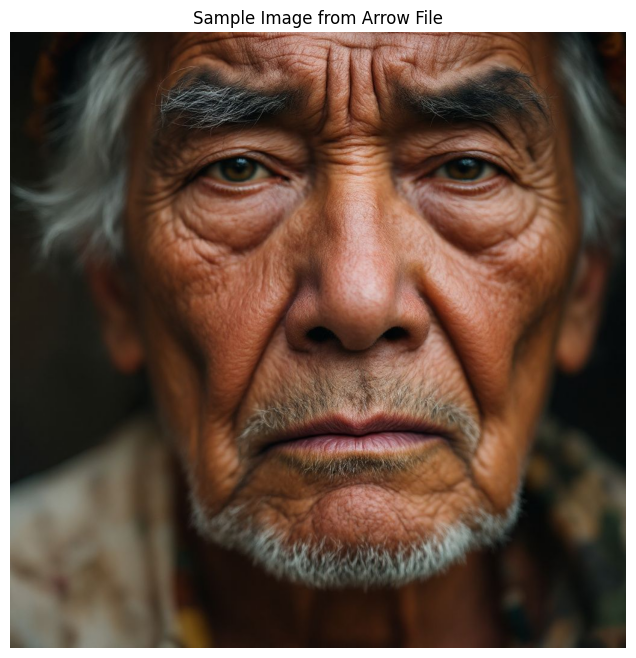

Metadata for displayed image:
path: /teamspace/studios/this_studio/flux2/9197.jpg
ind: 9198
Prompt: a focused close-up photo of a American Indian or Alaska Native man of 50 years with soft smooth skin who seems to genuinely experience impatience, irritability, irritation, restlessness, short-temperedness, exasperation. Strong facial expression of impatience, irritability, irritation, restlessness, short-temperedness, exasperation. No wrinkles
Age: 50
Ethnicity: American Indian or Alaska Native
Gender: man
Emotion: impatience, irritability, irritation, restlessness, short-temperedness, exasperation
image_metadata: {"path": "9197.jpg", "has_image": true}
image_binary: b'\xff\xd8\xff\xe1\x00\xbcExif\x00\x00II*\x00\x08\x00\x00\x00\x06\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00V\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00^\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x13\x02\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00i\x87\x04\x00\x01\x00\x00

In [113]:
# Display a sample image if available
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Get first row with image data
row_with_image = table.head(1)

    # Get binary data from the first row
image_bytes = row_with_image['image_binary'][0]

    # Convert to PIL Image
img = Image.open(io.BytesIO(image_bytes))

# resolution of the image
print(f"Image size: {img.size}")

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(np.array(img))
plt.title(f"Sample Image from Arrow File")
plt.axis('off')
plt.show()

# Show metadata for this image
print("Metadata for displayed image:")
for col in columns:
    if col in row_with_image.columns:
        print(f"{col}: {row_with_image[col][0]}")


### 🤗 Load Pretrained Model
Load a pretrained transformer model and processor for image embeddings.

In [ ]:
import torch
from transformers import AutoModel, AutoProcessor
from transformers.image_utils import load_image

# load the model and processor
ckpt = "google/siglip2-so400m-patch16-512"
model = AutoModel.from_pretrained(ckpt, device_map="auto").eval()
processor = AutoProcessor.from_pretrained(ckpt)


### 📊 Gender-Based Data Filtering
Separate the dataset by gender for further analysis.

In [ ]:

male_df = table[table.Gender == "man"]
woman_df = table[table.Gender == "woman" ]



### 🧮 Calculate Embeddings
Process images into embeddings for similarity analysis.

In [ ]:
from io import BytesIO
from PIL import Image
import torch.nn.functional as F

male_df = table[table.Gender == "man" ]
# load binaries and compute embeddings

emmbeddings = []

def load_image_for_embedding(binary_bytes):
    buf = BytesIO(binary_bytes)
    img = Image.open(buf).convert("RGB")
    return img
imgs = []
imgs += [load_image_for_embedding(b) .resize((512, 512), Image.BICUBIC) for b in woman_df["image_binary"].head(10).tolist() ]
        # preprocess & move to device
inputs = processor(images=imgs, return_tensors="pt")
with torch.no_grad():
    embs = model.get_image_features(**inputs)



#compute cosine similarity between the embedding
normalized_embeddings = F.normalize(embs, p=2, dim=1)
# normalized_embeddings will also have shape (100, 500)


similarity_matrix = torch.matmul(normalized_embeddings, normalized_embeddings.T)





In [ ]:
similarity_matrix
similarity_matrix = F.cosine_similarity(embs.unsqueeze(0), embs.unsqueeze(1), dim=2)
N = similarity_matrix.size(0) # Or N = 100 in your case


upper_triangle_indices = torch.triu_indices(N, N, offset=1)
unique_pairwise_similarities = similarity_matrix[upper_triangle_indices[0], upper_triangle_indices[1]]

unique_pairwise_similarities.mean(), unique_pairwise_similarities.std(), unique_pairwise_similarities.max(), unique_pairwise_similarities.min()


### 🖼️ Visualize Specific Image
Display a particular image using `load_image_for_embedding`.

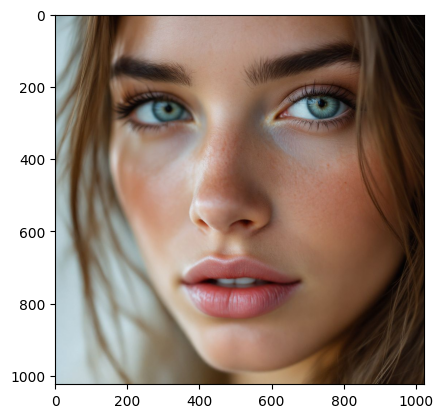

In [45]:
plt.imshow(load_image_for_embedding(table['image_binary'][2]))

### 🧠 Generate Embeddings
Iterate through images to compute and store embeddings.

In [ ]:
import torch
from tqdm.auto import tqdm
import pandas as pd
from transformers import AutoModel, AutoProcessor
from transformers.image_utils import load_image
from PIL import Image
from io import BytesIO


def load_image_for_embedding(binary_bytes):
    buf = BytesIO(binary_bytes)
    img = Image.open(buf).convert("RGB")
    return img




size = 384
ckpt = f"google/siglip2-so400m-patch14-{size}"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModel.from_pretrained(ckpt, device_map="auto").eval()
processor = AutoProcessor.from_pretrained(ckpt)


def compute_siglip2_embeddings_with_progress(
    binaries: list[bytes],
    batch_size: int = 16
) -> torch.Tensor:
    """
    binaries: list of image bytes
    returns: a (N, D) tensor of embeddings (on CPU)
    """
    all_embs = []
    total = len(binaries)
    n_batches = (total + batch_size - 1) // batch_size

    for i in tqdm(range(0, total, batch_size),
                  desc="SigLIP2 batches",
                  total=n_batches):
        batch = binaries[i : i + batch_size]
        # decode and downsample each image
        imgs = [
            load_image_for_embedding(b)
            .resize((size, size), Image.BICUBIC)
            for b in batch
        ]
        # preprocess & move to device
        inputs = processor(images=imgs, return_tensors="pt")
        with torch.no_grad():
            embs = model.get_image_features(**inputs)
        all_embs.append(embs.cpu())

    return torch.cat(all_embs, dim=0)




### 📥 Load Precomputed Embeddings
Load previously computed emotion-based embeddings.

In [ ]:
df_new = table.copy()

binaries = df_new['image_binary'].tolist()
indices  = df_new.index

emb_tensor = compute_siglip2_embeddings_with_progress(binaries, batch_size=128)

emb_np   = emb_tensor.numpy()                      
emb_list = [emb_np[i] for i in range(len(emb_np))]  

df_new['siglip2_emb'] = emb_list


df_new.to_parquet("emotion_embeddings.parquet")

SigLIP2 batches:   0%|          | 0/271 [00:00<?, ?it/s]

### 📊 Visualization Setup
Load additional libraries for plotting and similarity heatmaps.

In [2]:
df = pd.read_parquet("emotion_embeddings.parquet")

### Plot various embedding combinations


/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/ipykernel_16435/378733755.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


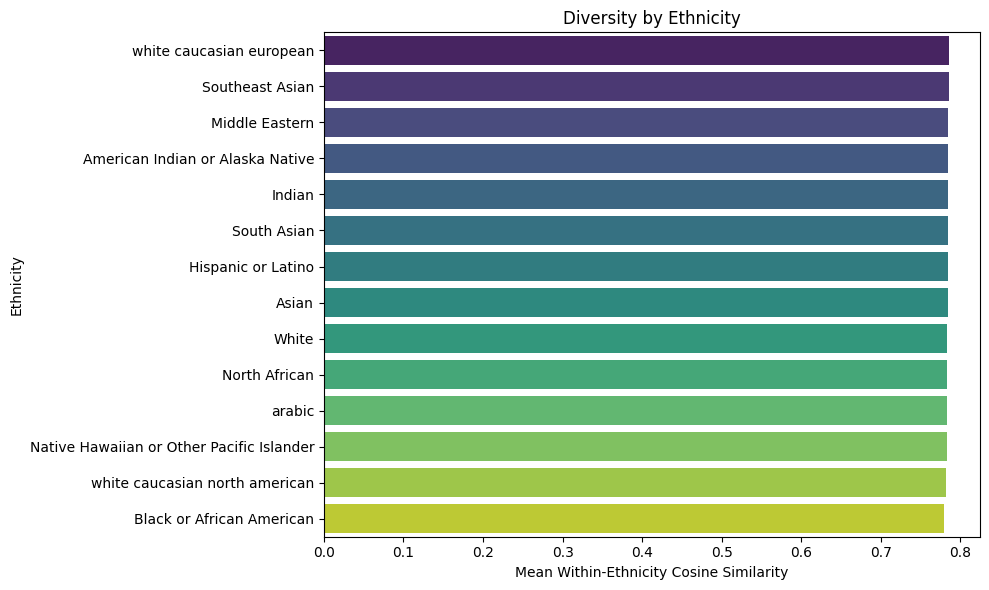

/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/ipykernel_16435/378733755.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


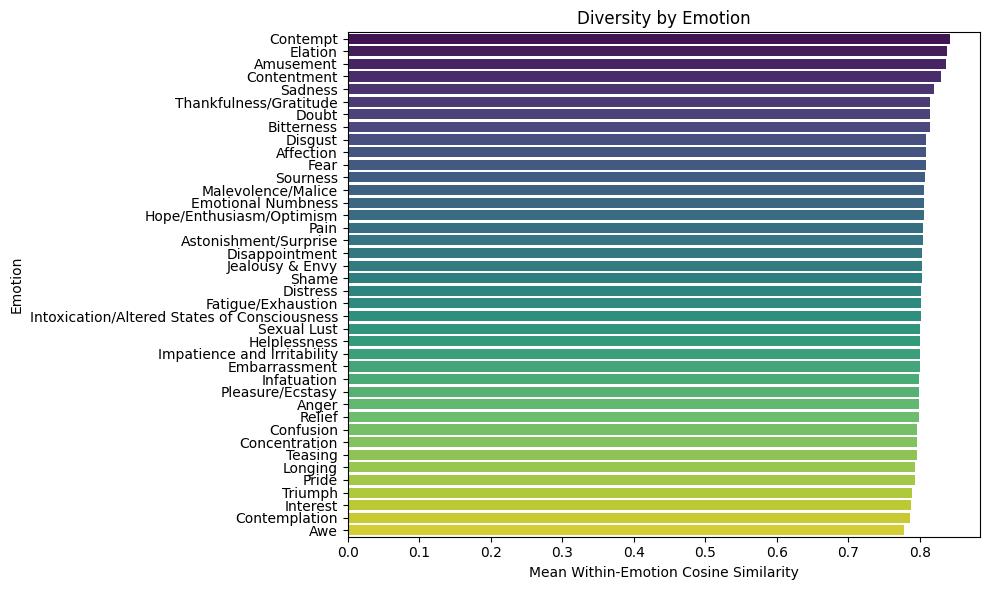

/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/ipykernel_16435/378733755.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


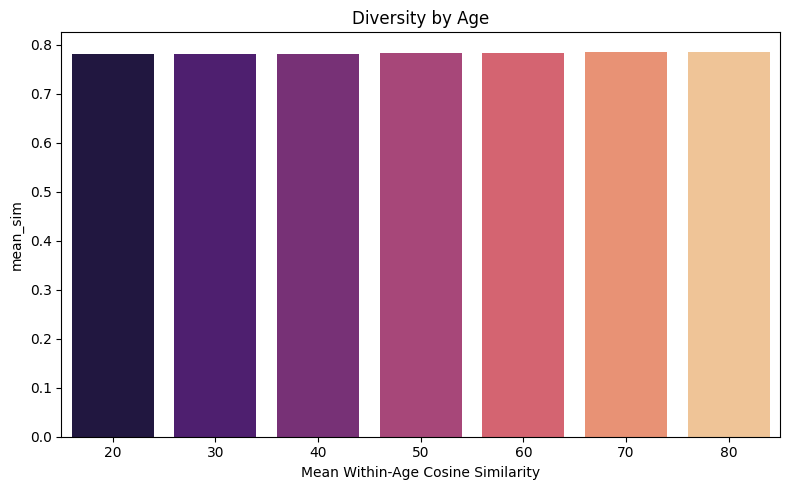

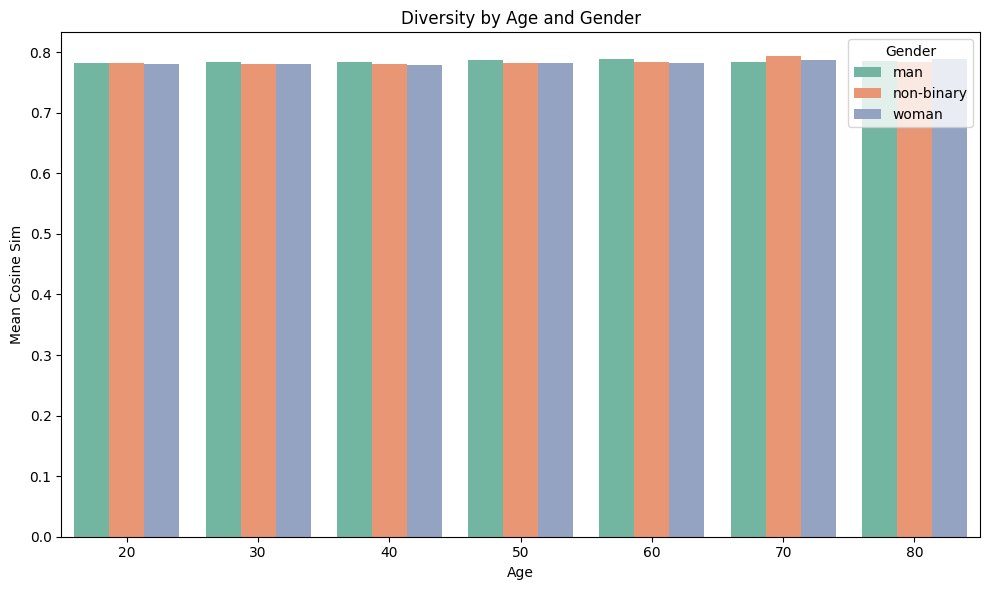

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ————————————————
# 1. Generalized per-group similarity calculator
# ————————————————
def compute_group_sims(df, group_cols, emb_col='siglip2_emb', min_count=2):
    """
    df: your DataFrame
    group_cols: either a string or list of cols to group by
    emb_col: name of the column with the embedding arrays
    min_count: skip any group with fewer than this many images
    Returns: DataFrame with columns group_cols + [count, mean_sim, std_sim]
    """
    if isinstance(group_cols, str):
        group_cols = [group_cols]
    records = []
    for keys, grp in df.groupby(group_cols):
        n = len(grp)
        if n < min_count:
            continue
        embs = np.stack(grp[emb_col].values)
        sims = cosine_similarity(embs,embs)
        iu = np.triu_indices_from(sims, k=1)
        pair_sims = sims[iu]
        records.append({
            **(dict(zip(group_cols, keys)) if isinstance(keys, tuple) else {group_cols[0]: keys}),
            'count': n,
            'mean_sim': pair_sims.mean(),
            'std_sim': pair_sims.std()
        })
    return pd.DataFrame(records)

# ————————————————
# 2. Compute all the one-col stats you had before
# ————————————————
emotion_sims   = compute_group_sims(df, 'Emotion_label')
button_sims    = compute_group_sims(df, 'Emotion_button')
gender_sims    = compute_group_sims(df, 'Gender')
ethnicity_sims = compute_group_sims(df, 'Ethnicity')
age_sims       = compute_group_sims(df, 'Age')

# ————————————————
# 3. Compute multi-col stats
# ————————————————
age_gender_sims     = compute_group_sims(df, ['Age','Gender'])
emotion_age_sims    = compute_group_sims(df, ['Emotion_label','Age'])
emotion_gender_sims = compute_group_sims(df, ['Emotion_button','Gender'])

# ————————————————
# 4. Your existing plots (example for Emotion_label & Age)
# ————————————————
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ethnicity_sims.sort_values('mean_sim', ascending=False),
    y='Ethnicity', x='mean_sim',
    palette='viridis'
)
plt.xlabel("Mean Within-Ethnicity Cosine Similarity")
plt.ylabel("Ethnicity")
plt.title("Diversity by Ethnicity")
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
sns.barplot(
    data=emotion_sims.sort_values('mean_sim', ascending=False),
    y='Emotion_label', x='mean_sim',
    palette='viridis'
)
plt.xlabel("Mean Within-Emotion Cosine Similarity")
plt.ylabel("Emotion")
plt.title("Diversity by Emotion")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=age_sims.sort_values('mean_sim', ascending=False),
    y='mean_sim', x='Age',
    palette='magma',
    capsize=.2,
    errorbar=('sd', None)
)
plt.xlabel("Mean Within-Age Cosine Similarity")
plt.title("Diversity by Age")
plt.tight_layout()
plt.show()

# ————————————————
# 5. New multi-col visualizations
# ————————————————

# a) Age × Gender (barplot with hue)
ag = age_gender_sims[age_gender_sims['count'] >= 10]
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ag,
    x='Age', y='mean_sim', hue='Gender',
    palette='Set2', capsize=.1,
    errorbar=('sd', None)
)
plt.ylabel("Mean Cosine Sim")
plt.title("Diversity by Age and Gender")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()




In [4]:
# df rename Gender = non-binary person to non-binary
df.loc[df['Gender'] == "non-binary person", 'Gender'] = "non-binary"

ethnicities = df["Ethnicity"].unique()
ages = df["Age"].unique()
emotions = df["Emotion_label"].unique()
emotion_buttons = df["Emotion_button"].unique()
gender = df["Gender"].unique()

ethnicities, ages, emotions, emotion_buttons, gender




(array(['American Indian or Alaska Native',
        'white caucasian north american', 'Middle Eastern',
        'North African', 'Asian', 'White', 'South Asian',
        'white caucasian european', 'Hispanic or Latino',
        'Southeast Asian', 'arabic',
        'Native Hawaiian or Other Pacific Islander',
        'Black or African American', 'Indian'], dtype=object),
 array([50, 60, 40, 80, 20, 30, 70]),
 array(['Impatience and Irritability', 'Doubt', 'Infatuation', 'Interest',
        'Pain', 'Fatigue/Exhaustion', 'Fear', 'Helplessness', 'Disgust',
        'Confusion', 'Malevolence/Malice', 'Awe', 'Amusement', 'Triumph',
        'Affection', 'Shame', 'Contemplation', 'Concentration',
        'Astonishment/Surprise', 'Thankfulness/Gratitude', 'Sourness',
        'Pride', 'Emotional Numbness', 'Relief', 'Pleasure/Ecstasy',
        'Distress', 'Sadness', 'Contempt', 'Jealousy & Envy',
        'Disappointment', 'Intoxication/Altered States of Consciousness',
        'Hope/Enthusiasm/Op

In [43]:
import pandas as pd

# 1. Count how often each exact combo appears
combo_counts = (
    df.groupby(["Age","Gender","Ethnicity","Emotion_label"]) #,"Emotion_button"])
      .size()
      .reset_index(name="count")
)

# 2. Pick, say, the top 100 most common combos
top_combos = combo_counts.nlargest(100, "count")[
    ["Age","Gender","Ethnicity","Emotion_label"] #,"Emotion_button"]
]

# 3. Merge back to filter your main df
df_top = df.merge(top_combos, on=["Age","Gender","Ethnicity","Emotion_label"]) #,"Emotion_button"])


In [44]:
top_combos

,Age,Gender,Ethnicity,Emotion_label
953,20,woman,Native Hawaiian or Other Pacific Islander,Distress
5044,60,man,Hispanic or Latino,Distress
7294,70,woman,White,Relief
4477,50,woman,Asian,Contentment
7629,80,man,Native Hawaiian or Other Pacific Islander,Contempt
...,...,...,...,...
7149,70,woman,Native Hawaiian or Other Pacific Islander,Malevolence/Malice
7744,80,man,Southeast Asian,Distress
7774,80,man,White,Contemplation
7813,80,man,arabic,Contentment


### 🌡️ Compute Similarities for Heatmaps
Compute and visualize cosine similarities using heatmaps.

/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/ipykernel_259552/2337811427.py:37: RuntimeWarning: Mean of empty slice.
  M[i, j] = vals.mean()
/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/emo-stats/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


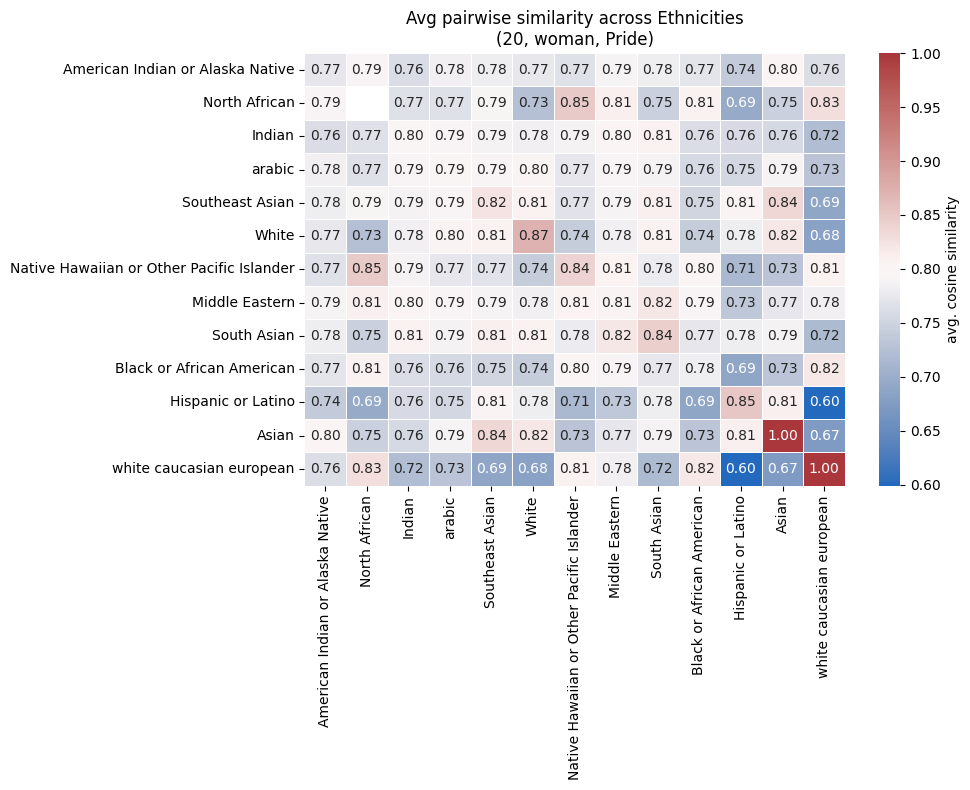

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Pick your fixed filter
base_mask = (
    (df["Age"] == 20) &
    (df["Gender"] == "woman") &
    (df["Emotion_label"] == "Pride")
)

# 2) Group embeddings by ethnicity
groups = {
    eth: np.stack(df.loc[base_mask & (df["Ethnicity"] == eth), "siglip2_emb"].values)
    for eth in df.loc[base_mask, "Ethnicity"].unique()
}

labels = list(groups.keys())
n = len(labels)
M = np.zeros((n, n))

# 3) Fill M[i,j] with the mean of all pairwise sims between groups[i] and groups[j]
for i, li in enumerate(labels):
    embs_i = groups[li]
    for j, lj in enumerate(labels):
        embs_j = groups[lj]
        if i == j:
            # within‐group: ignore self‐to‐self by taking upper tri
            sims = cosine_similarity(embs_i)
            iu = np.triu_indices_from(sims, k=1)
            vals = sims[iu]
        else:
            # cross‐group
            vals = cosine_similarity(embs_i, embs_j).flatten()
        M[i, j] = vals.mean()

# 4) Plot it
sim_df = pd.DataFrame(M, index=labels, columns=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_df,
    annot=True, fmt=".2f",
    cmap="vlag",
    cbar_kws={"label": "Cosine similarity"},
    linewidths=0.5
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Pairwise Similarity across Ethnicities\n(20, woman, Pride)")
plt.tight_layout()
plt.show()


### 🌡️ Plot Heatmaps
Generate similarity heatmaps to compare embedding clusters.

## Heatmaps

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# 1) define your age groups
age_groups = [
    (20, 30),
    (40, 50),
    (60, 80),
]

# 2) list of genders and emotion buttons
genders = df.Gender.unique()
emotion_buttons = df.Emotion_button.unique()

# 3) helper to compute the avg-pairwise sim matrix over ethnicities
def ethnicity_similarity(mask):
    groups = {
        eth: np.stack(df.loc[mask & (df["Ethnicity"] == eth), "siglip2_emb"].values)
        for eth in df.loc[mask, "Ethnicity"].unique()
    }
    labels = list(groups.keys())
    n = len(labels)
    M = np.zeros((n, n))
    for i, li in enumerate(labels):
        embs_i = groups[li]
        for j, lj in enumerate(labels):
            embs_j = groups[lj]
            if i == j:
                sims = cosine_similarity(embs_i)
                iu = np.triu_indices_from(sims, k=1)
                vals = sims[iu]
            else:
                vals = cosine_similarity(embs_i, embs_j).flatten()
            M[i, j] = vals.mean()
    return pd.DataFrame(M, index=labels, columns=labels)

# 4) set a larger context
sns.set_context("paper", font_scale=1.2)  # makes all text larger by default

for emo in emotion_buttons:
    for gen in genders:
        for (a_low, a_high) in age_groups:
            mask = (
                (df["Emotion_button"] == emo) &
                (df["Gender"] == gen) &
                (df["Age"] >= a_low) &
                (df["Age"] <= a_high)
            )
            if mask.sum() == 0:
                continue  # skip empty slices

            sim_df = ethnicity_similarity(mask)

            # Really big figure:
            fig, ax = plt.subplots(figsize=(14, 12), dpi=100)
            sns.heatmap(
                sim_df,
                ax=ax,
                # cmap="coolwarm",
                cmap="vlag",
                vmin=0.6, vmax=1.0,
                cbar_kws={"label": "Avg cosine similarity"},
                annot=True,
                fmt=".2f",
                annot_kws={"fontsize": 7},  # bump annotation text
                linewidths=0.4,
                square=True                 # make cells square
            )
            ax.set_title(f"{emo}  —  {gen}, Age {a_low}–{a_high}", pad=16)
            ax.set_xlabel("Ethnicity")
            ax.set_ylabel("Ethnicity")
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()


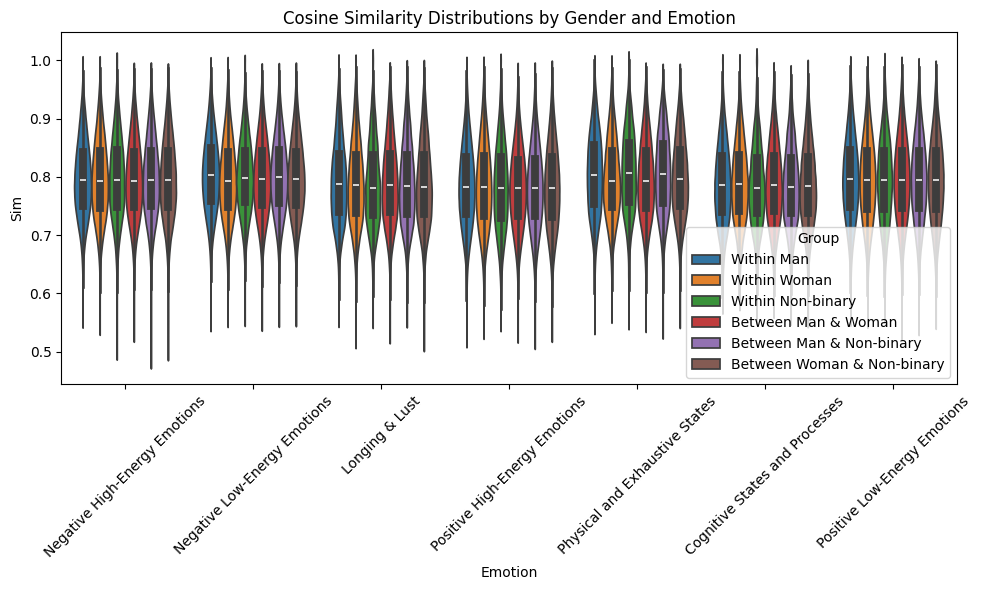

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function
def upper_tri_sims(embs1, embs2=None):
    if embs2 is None:
        sims = cosine_similarity(embs1)
        iu = np.triu_indices_from(sims, k=1)
        return sims[iu]
    else:
        sims = cosine_similarity(embs1, embs2)
        return sims.ravel()

# Prepare an empty list to collect data for plotting
results = []

# Filter out valid genders only
valid_genders = ["man", "woman", "non-binary"]

# Iterate over each Emotion_button value
for emotion in df['Emotion_button'].dropna().unique():
    df_e = df[df['Emotion_button'] == emotion]

    # Extract embeddings by gender
    embs = {}
    for gender in valid_genders:
        gender_embs = df_e[df_e['Gender'] == gender]['siglip2_emb']
        if len(gender_embs) >= 2:  # Need at least 2 for within-group similarity
            embs[gender] = np.stack(gender_embs)

    # Compute within-group similarities
    for gender, arr in embs.items():
        sims = upper_tri_sims(arr)
        results.extend([{
            "Emotion": emotion,
            "Group": f"Within {gender.capitalize()}",
            "Sim": sim
        } for sim in sims])

    # Compute between-group similarities
    gender_pairs = [(g1, g2) for i, g1 in enumerate(embs) for g2 in list(embs)[i+1:]]
    for g1, g2 in gender_pairs:
        sims = upper_tri_sims(embs[g1], embs[g2])
        results.extend([{
            "Emotion": emotion,
            "Group": f"Between {g1.capitalize()} & {g2.capitalize()}",
            "Sim": sim
        } for sim in sims])

# Convert to DataFrame
df_plot = pd.DataFrame(results)

# --- Violin Plot per Emotion ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_plot, x="Emotion", y="Sim", hue="Group", split=False)
plt.title("Cosine Similarity Distributions by Gender and Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
